In [1]:
import tensorstore as ts
import matplotlib.pyplot as plt

In [2]:
import functools as ft

import numpy as np

import jax
import jax.numpy as jnp

from sofima import mesh
from sofima import flow_field
from sofima import stitch_rigid

# from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [5]:
import zarr_io

bucket = 'sofima-test-bucket'
path_0 = f'preprocessed_0.zarr'  
path_1 = f'preprocessed_1.zarr'
tile_0 = zarr_io.open_zarr(bucket, path_0)
tile_1 = zarr_io.open_zarr(bucket, path_1)

dataset0 = tile_0
dataset = tile_1

In [ ]:
ds1 = ts.open({
    'driver': 'zarr',
    'kvstore': {
        'driver': 'gfile',
        'path': f'/bigstore/sofima-test-bucket/preprocessed_1.zarr'
    },
})
dataset = ds1.result()

In [10]:
ds0 = ts.open({
    'driver': 'zarr',
    'kvstore': {
        'driver': 'gfile',
        'path': f'/bigstore/sofima-test-bucket/preprocessed_0.zarr'
    },
})
dataset0 = ds0.result()

In [6]:
d1 = dataset[0, 0, :, :, :].read().result()

In [7]:
d0 = dataset0[0, 0, :, :, :].read().result()

In [8]:
d0 = d0.T
d1 = d1.T

In [9]:
tile_size_xyz = d0.shape

In [10]:
tile_size_xyz

(576, 576, 3544)

In [11]:
# d1 zyx absolute position: [-2, 288, 6] per manual Neuroglancer optimization
# overlap = 576 - 288 = 288
bot = d1
top = d0

In [12]:
d1.shape, d0.shape  # XYZ

((576, 576, 3544), (576, 576, 3544))

In [13]:
# Size of the 'query' cuboid in the preceding tile.
QUERY_R_ORTHO = 25
QUERY_R_OVERLAP = 25

# Size of the search area in the following tile.
SEARCH_OVERLAP = 300
SEARCH_R_ORTHO = 50

assert SEARCH_R_ORTHO > QUERY_R_ORTHO
assert SEARCH_OVERLAP > 2 * QUERY_R_OVERLAP

@ft.partial(jax.jit, static_argnames=('overlap',))
def _estimate_vert(top, bot, overlap):
  return r[0]

In [14]:
mz = tile_size_xyz[2] // 2
mx = tile_size_xyz[0] // 2

In [15]:
overlap = SEARCH_OVERLAP

In [16]:
# data is now zyx
top = d0[mx-SEARCH_R_ORTHO:mx+SEARCH_R_ORTHO, tile_size_xyz[1]-overlap:, mz-SEARCH_R_ORTHO:mz+SEARCH_R_ORTHO].T
bot = d1[mx-QUERY_R_ORTHO:mx+QUERY_R_ORTHO, 0:QUERY_R_OVERLAP*2, mz-QUERY_R_ORTHO:mz+QUERY_R_ORTHO].T

In [25]:
xc = flow_field.masked_xcorr(bot, top, use_jax=True, dim=3)
xc = xc.astype(np.float32)
xc = xc[None, ...]

In [26]:
# offset vector is xyz
r = flow_field._batched_peaks(xc, ((xc.shape[1]) // 2, (xc.shape[2]) // 2, (xc.shape[3]) // 2), min_distance=2, threshold_rel=0.5)

In [19]:
bot.shape, top.shape

((50, 50, 50), (100, 300, 100))

In [27]:
# xyz
r

Array([[ -6.       , 113.       ,   4.       ,   1.0809387,   1.0466778]],      dtype=float32)

In [200]:
# offset in y will be exactly 0 if the two images are exactly aligned in the center, i.e. if
# 'bot' is placed at this value relative to the start of 'top'
start_zyx = np.array(top.shape) // 2 - np.array(bot.shape) // 2
start_zyx

array([ 25, 125,  25])

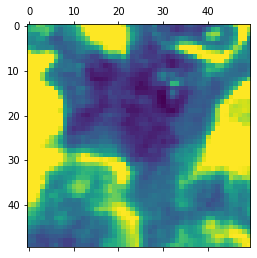

In [201]:
# We're looking for this fragment:
plt.matshow(bot[QUERY_R_ORTHO, ...].T)

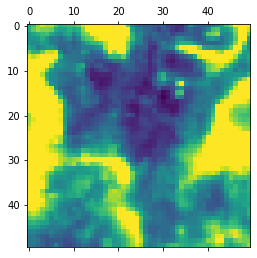

In [202]:
# in this area..
x0 = int(start_zyx[2] - r[0][0])
y0 = int(start_zyx[1] - r[0][1])
z0 = int(start_zyx[0] - r[0][2])

plt.matshow(top[z0 + QUERY_R_ORTHO, y0:y0+QUERY_R_OVERLAP * 2, x0:x0 + QUERY_R_ORTHO * 2].T)

In [204]:
# Ideally, the two images above should look almost identical.

In [213]:
# Translating these reults into an offset for 'bot', assuming 'top' is fixed at (0, 0, 0).
int(-r[0][0]), overlap - y0, int(-r[0][2])

(6, 288, -4)

In [ ]:
# Visualize results in Neuroglancer:
https://neuroglancer-demo.appspot.com/#!%7B%22dimensions%22:%7B%22d0%22:%5B1%2C%22%22%5D%2C%22d1%22:%5B1%2C%22%22%5D%2C%22d2%22:%5B1%2C%22%22%5D%2C%22d3%22:%5B1%2C%22%22%5D%2C%22d4%22:%5B1%2C%22%22%5D%7D%2C%22displayDimensions%22:%5B%22d4%22%2C%22d3%22%2C%22d2%22%5D%2C%22position%22:%5B0.5%2C0.5%2C1736.5%2C318.348876953125%2C287.4121398925781%5D%2C%22crossSectionScale%22:0.26605859931413917%2C%22projectionScale%22:4096%2C%22layers%22:%5B%7B%22type%22:%22image%22%2C%22source%22:%22zarr://gs://sofima-test-bucket/preprocessed_0.zarr%22%2C%22tab%22:%22source%22%2C%22shader%22:%22#uicontrol%20invlerp%20normalized%5Cnvoid%20main%28%29%20%7B%5Cn%20%20emitRGB%28vec3%28normalized%28%29%2C%200.0%2C%200.0%29%29%3B%5Cn%7D%5Cn%22%2C%22name%22:%22preprocessed_0.zarr%22%7D%2C%7B%22type%22:%22image%22%2C%22source%22:%7B%22url%22:%22zarr://gs://sofima-test-bucket/preprocessed_1.zarr%22%2C%22transform%22:%7B%22matrix%22:%5B%5B1%2C0%2C0%2C0%2C0%2C0%5D%2C%5B0%2C1%2C0%2C0%2C0%2C0%5D%2C%5B0%2C0%2C1%2C0%2C0%2C-4%5D%2C%5B0%2C0%2C0%2C1%2C0%2C288%5D%2C%5B0%2C0%2C0%2C0%2C1%2C6%5D%5D%2C%22outputDimensions%22:%7B%22d0%22:%5B1%2C%22%22%5D%2C%22d1%22:%5B1%2C%22%22%5D%2C%22d2%22:%5B1%2C%22%22%5D%2C%22d3%22:%5B1%2C%22%22%5D%2C%22d4%22:%5B1%2C%22%22%5D%7D%7D%7D%2C%22tab%22:%22source%22%2C%22shader%22:%22#uicontrol%20invlerp%20normalized%5Cnvoid%20main%28%29%20%7B%5Cn%20%20emitRGB%28vec3%280.%2C%20normalized%28%29%2C%200.0%29%29%3B%5Cn%5Cn%7D%5Cn%22%2C%22name%22:%22preprocessed_1.zarr%22%7D%5D%2C%22selectedLayer%22:%7B%22visible%22:true%2C%22layer%22:%22preprocessed_1.zarr%22%7D%2C%22layout%22:%22xy%22%7D

Despite language of 'search' and 'query', this example actually has the search space moving as a kernel against a fixed padded query tile. 

Offset of [-6, 113, 4] represents how much the top tile should move. 

Simplified way (which removes a bunch of negatives) is to actually fix the search space like the termininology implies:

In [33]:
xc = flow_field.masked_xcorr(top, bot, use_jax=True, dim=3)
xc = xc.astype(np.float32)
xc = xc[None, ...]
r = flow_field._batched_peaks(xc, ((xc.shape[1]) // 2, (xc.shape[2]) // 2, (xc.shape[3]) // 2), min_distance=2, threshold_rel=0.5)
start_zyx = np.array(top.shape) // 2 - np.array(bot.shape) // 2

mx = tile_size_xyz[0] // 2
mz = tile_size_xyz[2] // 2

offset_xyz = np.array([mx - SEARCH_R_ORTHO, tile_size_xyz[1] - overlap, mz - SEARCH_R_ORTHO]) \
           + np.array([start_zyx[2], start_zyx[1], start_zyx[0]]) \
           + np.array(r[0][0:3])

print(np.array([mx - SEARCH_R_ORTHO, tile_size_xyz[1] - overlap, mz - SEARCH_R_ORTHO]))
print(np.array([start_zyx[2], start_zyx[1], start_zyx[0]]))
print(np.array(r[0][0:3]))

print(offset_xyz)
# This is computing a slightly different quantity-- placement of query patch
# about the origin. What we really want is the displacement of the neighbor tile
# relative to the base tile coords. 

# Therefore, x/z components can be directly extracted from phase correlation
# whereas displacement in y component requires knowing initial y position
# where phase correlation is initialized. Relative y offset starts with a relative y offset. 

[ 238  276 1722]
[ 25 125  25]
[   6. -113.   -4.]
[ 269.  288. 1743.]


In [34]:
# By doing patch-based phase correlation we are implicitly defining 
# a relative y offset to begin with -- where the centers of the patches align. 

# Final simplified answer: 
xc = flow_field.masked_xcorr(top, bot, use_jax=True, dim=3)
xc = xc.astype(np.float32)
xc = xc[None, ...]
r = flow_field._batched_peaks(xc, ((xc.shape[1]) // 2, (xc.shape[2]) // 2, (xc.shape[3]) // 2), min_distance=2, threshold_rel=0.5)
start_zyx = np.array(top.shape) // 2 - np.array(bot.shape) // 2

initial_relative_offset = np.array([0, tile_size_xyz[1] - overlap + start_zyx[1], 0])
pc_relative_offset = np.array(r[0][0:3])
offset_xyz = initial_relative_offset + pc_relative_offset
print(offset_xyz)


[  6. 288.  -4.]
